#Ensemble Learning


A group of pre dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.

Ensemble methods, including bagging, boosting and stacking.

##Bagging and Pasting


One way to get a diverse set of classifiers is to use very different training algorithms,
as just discussed. Another approach is to use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
sampling is performed with replacement, this method is called bagging
(short for
bootstrap aggregating
). When sampling is performed without replacement, it is called
pasting.

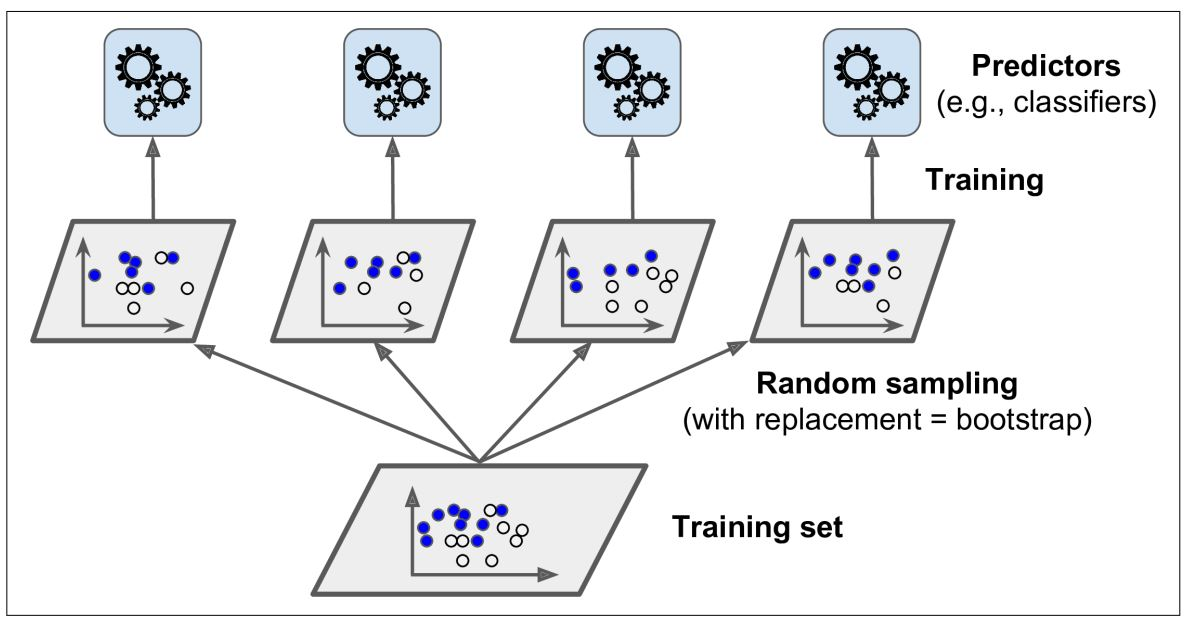

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e. the most frequent prediction, for classification, or the average for regression.

Each individual predictor has a higher bias than if it were trained on the original training set, but
aggregation reduces both bias and variance.
 Generally, the net result is that the
ensemble has a similar bias but a lower variance than a single predictor trained on the
original training set.

**Bagging and Pasting in Scikit-Learn**

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClas
sifier class (or BaggingRegressor for regression). The following code trains an
ensemble of 500 Decision Tree classifiers,5
each trained on 100 training instances ran‐
domly sampled from the training set with replacement (this is an example of bagging,
but if you want to use pasting instead, just set bootstrap=False). The n_jobs param‐
eter tells Scikit-Learn the number of CPU cores to use for training and predictions
(–1 tells Scikit-Learn to use all available cores):

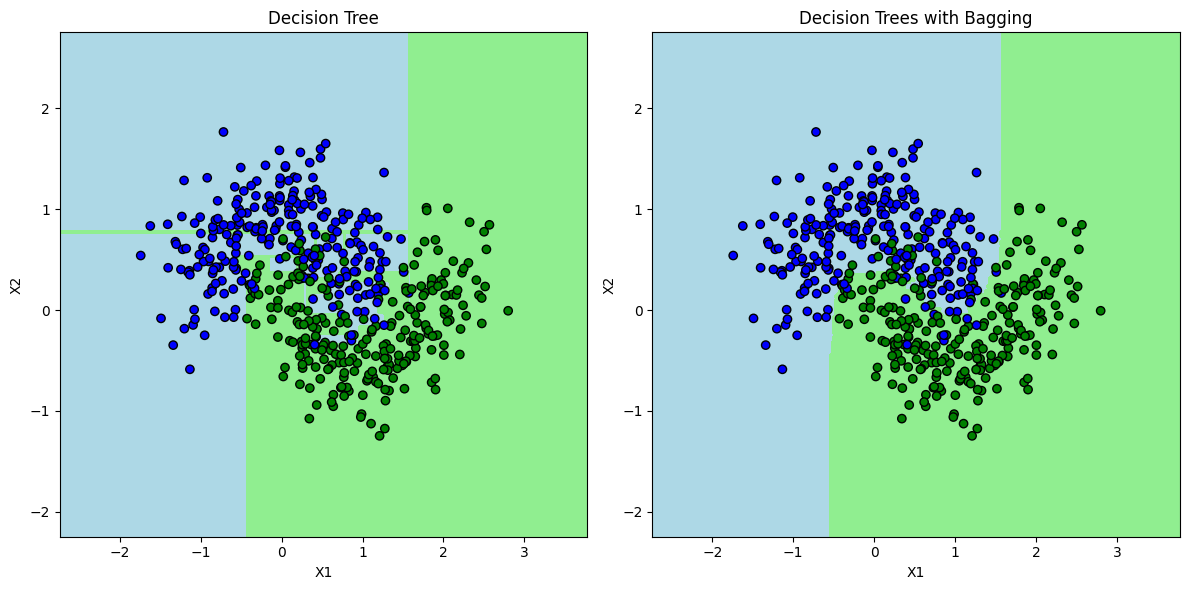

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap
import numpy as np


# Generate the moons dataset
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

# Create the BaggingClassifier with DecisionTreeClassifier base estimator
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)

# Function to plot the decision boundaries
def plot_decision_boundary(clf, X, y, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['lightblue', 'lightgreen'])
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['blue', 'green']), edgecolor='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")

# Visualize the decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(dt_clf, X, y, "Decision Tree")

plt.subplot(1, 2, 2)
plot_decision_boundary(bag_clf, X, y, "Decision Trees with Bagging")

plt.tight_layout()
plt.show()

The decision boundary of a single decision tree can be influenced by outliers, while Bagging can help reduce this sensitivity. This is one of the advantages of using ensemble methods like Bagging for classification tasks, especially when dealing with noisy or outlier-prone data.

**Out-of-Bag Evaluation**

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor.6
 The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
for all predictors.
Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. You can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.
In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to
request an automatic oob evaluation after training. The following code demonstrates
this. The resulting evaluation score is available through the oob_score_ variable:

In [ ]:
bag_clf = BaggingClassifier(
... DecisionTreeClassifier(), n_estimators=500,
... bootstrap=True, n_jobs=-1, oob_score=True)
...
>>> bag_clf.fit(X_train, y_train)


BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

In [ ]:
bag_clf.oob_score_


0.905

According to this oob evaluation, this BaggingClassifier is likely to achieve about
90% accuracy on the test set. Let’s verify this:


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.89

We get 89% accuracy on the test set—close enough!

##Random Forests

a Random Forest9
 is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set. Instead of building a BaggingClassifier and pass‐
ing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier
class, which is more convenient and optimized for Decision Trees10 (similarly, there is
a RandomForestRegressor class for regression tasks). The following code trains a
Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using
all available CPU cores:


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)


The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node, it
searches for the best feature among a random subset of features. This results in a
greater tree diversity, which (once again) trades a higher bias for a lower variance,
generally yielding an overall better model.

**Feature Importance**

Yet another great quality of Random Forests is that they make it easy to measure the
relative importance of each feature. Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest). More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it.
Scikit-Learn computes this score automatically for each feature after training, then it
scales the results so that the sum of all importances is equal to 1. You can access the
result using the feature_importances_ variable.

In [ ]:
from sklearn.datasets import load_iris
>>> iris = load_iris()
>>> rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
>>> rnd_clf.fit(iris["data"], iris["target"])
>>> for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
      print(name, score)

sepal length (cm) 0.09809141851498673
sepal width (cm) 0.024311929746272446
petal length (cm) 0.42050003494086
petal width (cm) 0.4570966167978809


For example, the above code
trains a RandomForestClassifier on the iris dataset and
outputs each feature’s importance. It seems that the most important features are the
petal length (42%) and width (45%), while sepal length and width are rather unimportant in comparison (9% and 2%, respectively)